# Sampling from a multivariate Gaussian using a GAN
In this example we'll try to learn a generator sampling from a simple $N$-dimensional multivariate Gaussian.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

# vegans imports:
from vegans import WGANGP
from vegans.utils import plot_losses

ngpu = 0

In [2]:
nz = 5  # noise vector size
N = 20  # size of sampled vectors

## Prepare the "training" dataset
First, we define a $NxN$ covariance matrix, and plot it:

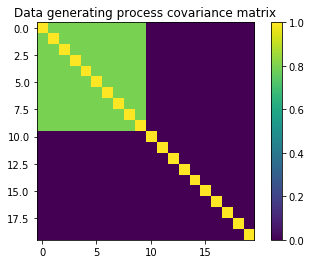

In [4]:
cov_mat = np.zeros((N,N))
cov_mat[0:10,0:10] = 0.8
np.fill_diagonal(cov_mat, 1.)

plt.imshow(cov_mat)
plt.title('Data generating process covariance matrix')
plt.colorbar();

Our goal will be to train a generator network in a GAN setting, which can sample from a distribution with a similar covariance matrix.

For reference, here's the sample covariance matrix, obtained when sampling from this distribution:

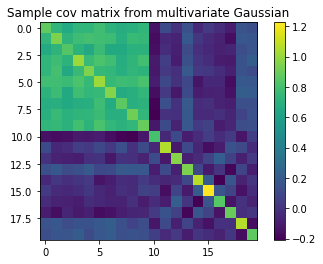

In [5]:
samples = np.random.multivariate_normal(mean=np.array([0. for _ in range(N)]), cov=cov_mat, size=100)

# re-cover matrix
cov_mat_recovered = np.cov(samples.T)

plt.imshow(cov_mat_recovered)
plt.title('Sample cov matrix from multivariate Gaussian');
plt.colorbar();

Training with VeGANs requires a `torch.utils.data.DataLoader`, so let's create one that will sample from our distribution (and just returning dummy labels):

In [6]:
class GaussianDataset(Dataset):
    def __getitem__(self, idx):
        return np.random.multivariate_normal(mean=np.array([0. for _ in range(N)]), cov=cov_mat).astype(np.float32), 0

    def __len__(self):
        return 10000
    
dataset = GaussianDataset()
dataloader = DataLoader(dataset, batch_size=16)

Let's now have a look at the distribution of our (flattened) training set:

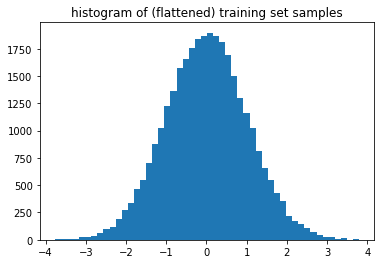

In [7]:
""" Look at our (flattened) data distribution
"""
vals = []
for _ in range(100):
    vals += list(next(iter(dataloader))[0].flatten())
plt.hist(vals, bins=50)
plt.title('histogram of (flattened) training set samples');

## Define our Generator and Critic Networks
Here we'll define some very simple nets.

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(nz, 10)
        self.fc2 = nn.Linear(10, N)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(N, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
critic = Critic()
generator = Generator()

We didn't train our generator yet, so it's just generating noise. What does the sample covariance matrix look like?

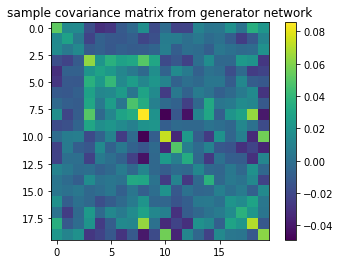

In [9]:
def plot_generator_cov(generator_):
    """ Try the generator on a noise mini-batch and compute sample covariance matrix
    """
    z = torch.from_numpy(np.random.randn(10000, nz).astype(np.float32))
    samples = generator_(z)
    cov_mat_est = np.cov(samples.detach().numpy().T)

    plt.imshow(cov_mat_est)
    plt.title('sample covariance matrix from generator network');
    plt.colorbar();
    
plot_generator_cov(generator)

## Time for training!
We'll use [WGAN-GP](https://arxiv.org/abs/1704.00028). Here we'll define our own optimizers for the generator and the critic, in order to use a slightly lower learning rate than the default one.

We'll train for 50 epochs.

In [10]:
optimizer_D = optim.Adam(critic.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

gan = WGANGP(generator, critic, dataloader, ngpu=ngpu, nr_epochs=50, nz=nz, print_every=1000, 
             optimizer_D=optimizer_D, optimizer_G=optimizer_G)

device: cpu


The training happens in the next cell. You can interrupt it at any time without loosing the results.

In [11]:
gan.train();

[1/50][375/625](- iter/s)	Loss_D: -0.56269372	Loss_G: 0.28131923
[3/50][125/625](262.741 iter/s)	Loss_D: -2.06073713	Loss_G: 1.42240143
[4/50][500/625](275.004 iter/s)	Loss_D: -3.82873821	Loss_G: 2.10550857
[6/50][250/625](272.690 iter/s)	Loss_D: -5.87769222	Loss_G: 2.23906517
[8/50][0/625](276.060 iter/s)	Loss_D: -4.12978268	Loss_G: 1.25697982
[9/50][375/625](260.286 iter/s)	Loss_D: -7.30092621	Loss_G: 0.58714747
[11/50][125/625](295.484 iter/s)	Loss_D: -2.53006792	Loss_G: -0.83288586
[12/50][500/625](300.361 iter/s)	Loss_D: -5.83199263	Loss_G: 0.16546917
[14/50][250/625](302.357 iter/s)	Loss_D: -10.26981735	Loss_G: 2.35391450
[16/50][0/625](301.428 iter/s)	Loss_D: -8.96004486	Loss_G: 3.13133001
[17/50][375/625](299.606 iter/s)	Loss_D: -14.80875015	Loss_G: 3.51622510
[19/50][125/625](298.594 iter/s)	Loss_D: -18.11277580	Loss_G: 2.50281239
[20/50][500/625](303.106 iter/s)	Loss_D: -15.64866638	Loss_G: -6.33028793
[22/50][250/625](303.685 iter/s)	Loss_D: -10.63686180	Loss_G: -5.13828516


## Inspection of results
By calling `get_training_results()` on any GAN object, you can get a list of samples (generated out of a fixed noise vector), as well as the lists of losses of the generator and discriminator:

In [12]:
samples_l, D_losses, G_losses = gan.get_training_results()

First, let's check what's the distribution of (flattened) samples during the last iteration:

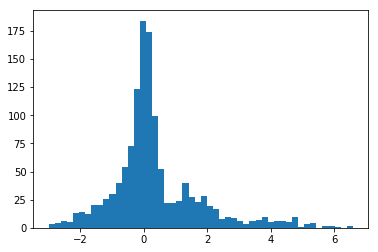

In [13]:
plt.hist(list(samples_l.items())[-1][1].detach().numpy().flatten(), bins=50);

And now let's look at the losses of the generator and critic during training - we can just call `vegans.utils.plot_losses()`:

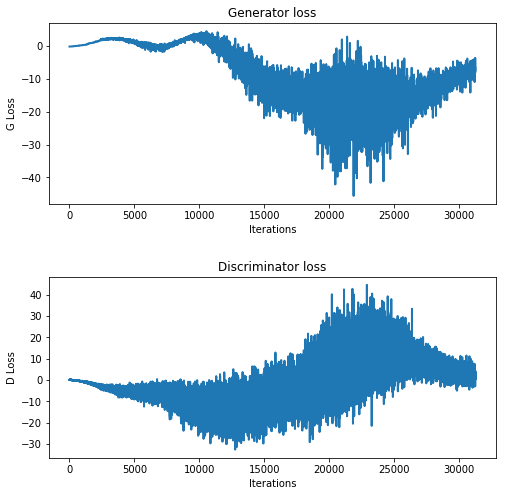

In [14]:
plot_losses(G_losses, D_losses)

And the sample covariance matrix we obtain we drawing samples from our newly-trained generator:

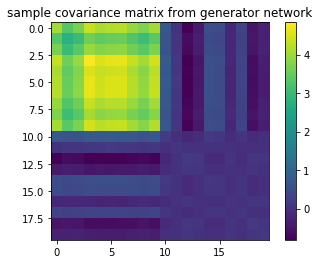

In [15]:
plot_generator_cov(generator)

It looks somewhat similar to the original matrix, except for the diagonal elements (can we do better??). Finally, here's the history of how this sample covariance matrix evolved over training:

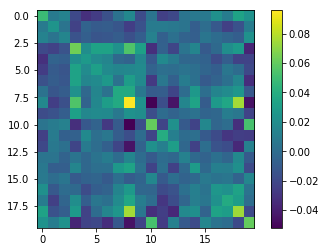

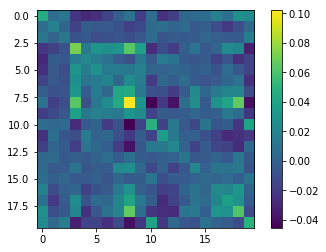

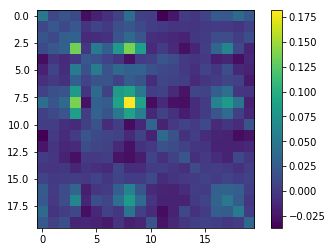

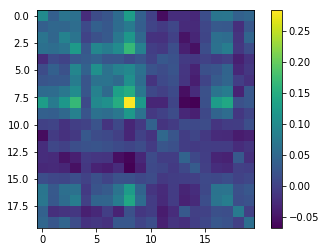

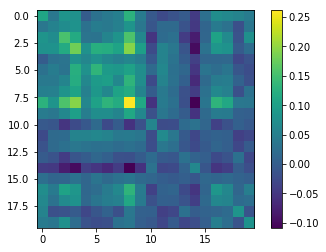

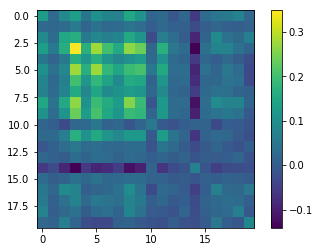

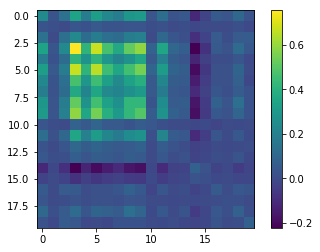

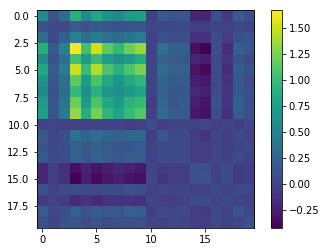

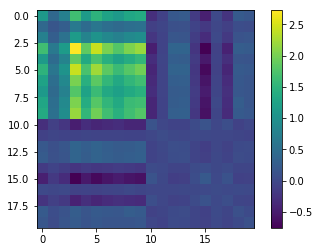

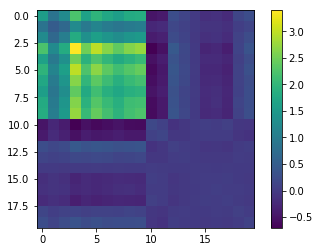

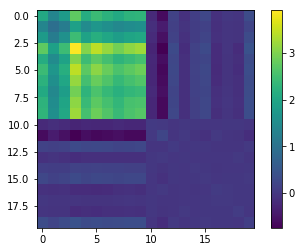

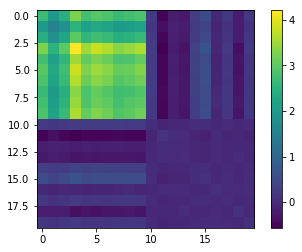

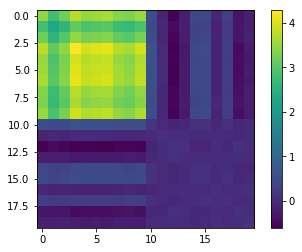

In [16]:
for i, (t, samples) in enumerate(samples_l.items()):
    if i % 5 != 0:
        continue
    sample_cov_mat = np.cov(np.array(samples).T)
    plt.figure()
    plt.imshow(sample_cov_mat)
    plt.colorbar();